In [2]:
import csv

def find_missing_numbers(input_csv, output_csv):
    # Read the integers from the input CSV
    with open(input_csv, 'r') as file:
        reader = csv.reader(file)
        #next(reader, None)  # Skip header
        numbers = [int(row[0]) for row in reader]

    # Find the missing numbers
    full_set = set(range(1, 19016))
    missing_numbers = sorted(list(full_set - set(numbers)))

    # Write the missing numbers to the output CSV
    with open(output_csv, 'w', newline='') as file:
        writer = csv.writer(file)
        #writer.writerow(['Missing Numbers'])  # Header
        for number in missing_numbers:
            writer.writerow([number])

# Example usage
input_csv = 'data/USC/train.csv'  # Replace with your input CSV file path
output_csv = 'data/USC/test.csv'  # The output file will be created with this name
find_missing_numbers(input_csv, output_csv)


In [6]:
!pip install pandas
!pip install torch
!pip install torchvision
!pip install scikit-image
!pip install matplotlib
!pip install torchsummary


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import zipfile
with zipfile.ZipFile('data/USC/Rx.zip', 'r') as zip_ref:
    zip_ref.extractall('../tmp')

In [20]:
from source.dataloader.loader_USC import PMnet_usc

usc_training_data=PMnet_usc('data/USC/train.csv', 'data/USC')
print(f"Number of samples in the training dataset: {len(usc_training_data)}")

usc_test_data=PMnet_usc('data/USC/test.csv', 'data/USC')
print(f"Number of samples in the test dataset: {len(usc_test_data)}")

from torch.utils.data import DataLoader

usc_training_dataloader = DataLoader(usc_training_data, batch_size=16, shuffle=True)
usc_test_dataloader = DataLoader(usc_test_data, batch_size=16, shuffle=True)

Number of samples in the training dataset: 15211
Number of samples in the test dataset: 3803


Sample image shape: torch.Size([2, 256, 256]), Sample label: torch.Size([1, 256, 256])


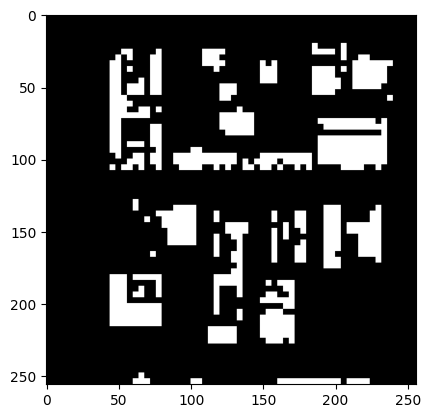

Feature batch shape: torch.Size([16, 2, 256, 256])
Labels batch shape: torch.Size([16, 1, 256, 256])


In [22]:
image, label = usc_training_data[0]  # Get the first sample
print(f"Sample image shape: {image.shape}, Sample label: {label.shape}")

import matplotlib.pyplot as plt

img_4_show = image[0,:,:].unsqueeze(0).permute(1,2,0)

plt.imshow(img_4_show.squeeze(), cmap='gray')
plt.show()

train_features, train_labels = next(iter(usc_training_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

In [11]:
from source.network.PMNet import PMNet
from torchsummary import summary
network = PMNet([3,3,3,3], [1,1,1], None, 16)
print(summary(network, (2,256,256), 16))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 64, 128, 128]           6,272
       BatchNorm2d-2         [16, 64, 128, 128]             128
              ReLU-3         [16, 64, 128, 128]               0
         MaxPool2d-4           [16, 64, 65, 65]               0
            Conv2d-5           [16, 64, 65, 65]           4,096
       BatchNorm2d-6           [16, 64, 65, 65]             128
              ReLU-7           [16, 64, 65, 65]               0
            Conv2d-8           [16, 64, 65, 65]          36,864
       BatchNorm2d-9           [16, 64, 65, 65]             128
             ReLU-10           [16, 64, 65, 65]               0
           Conv2d-11          [16, 256, 65, 65]          16,384
      BatchNorm2d-12          [16, 256, 65, 65]             512
           Conv2d-13          [16, 256, 65, 65]          16,384
      BatchNorm2d-14          [16, 256,

In [89]:
import torch.optim as optim

optimizer = optim.Adam(network.parameters())
scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer,step_size=10, gamma=0.5)

In [110]:
from evaluation.eval import ROI_RMSE_Loss

loss_fn = ROI_RMSE_Loss()

In [113]:
import torch.nn as nn

for epoch in range(1,2):
    network.train()
    for batch_idx, (data, target) in enumerate(usc_training_dataloader):
        optimizer.zero_grad()
        output = network(data)    
        roi = data[:, 0, :, :].unsqueeze(1)
        target_with_roi = torch.cat((target, roi), dim=1)
        loss = loss_fn(output,target_with_roi)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(usc_training_dataloader.sampler),
                    100.0 * batch_idx / len(usc_training_dataloader),
                    loss.item(),
                )
            )

ROI shape: {} torch.Size([16, 1, 256, 256])
Target with ROI shape: {} torch.Size([16, 2, 256, 256])
Train Epoch: 1 [0/15211 (0%)] Loss: 0.517527
ROI shape: {} torch.Size([16, 1, 256, 256])
Target with ROI shape: {} torch.Size([16, 2, 256, 256])
Train Epoch: 1 [16/15211 (0%)] Loss: 0.416127
ROI shape: {} torch.Size([16, 1, 256, 256])
Target with ROI shape: {} torch.Size([16, 2, 256, 256])
Train Epoch: 1 [32/15211 (0%)] Loss: 0.387073
ROI shape: {} torch.Size([16, 1, 256, 256])
Target with ROI shape: {} torch.Size([16, 2, 256, 256])
Train Epoch: 1 [48/15211 (0%)] Loss: 0.391319
ROI shape: {} torch.Size([16, 1, 256, 256])
Target with ROI shape: {} torch.Size([16, 2, 256, 256])
Train Epoch: 1 [64/15211 (0%)] Loss: 0.396915
ROI shape: {} torch.Size([16, 1, 256, 256])
Target with ROI shape: {} torch.Size([16, 2, 256, 256])
Train Epoch: 1 [80/15211 (1%)] Loss: 0.386089
ROI shape: {} torch.Size([16, 1, 256, 256])
Target with ROI shape: {} torch.Size([16, 2, 256, 256])
Train Epoch: 1 [96/15211 

KeyboardInterrupt: 

In [17]:
import torch

checkpoint = torch.load('model/model.pth')
network.load_state_dict(checkpoint)

<All keys matched successfully>

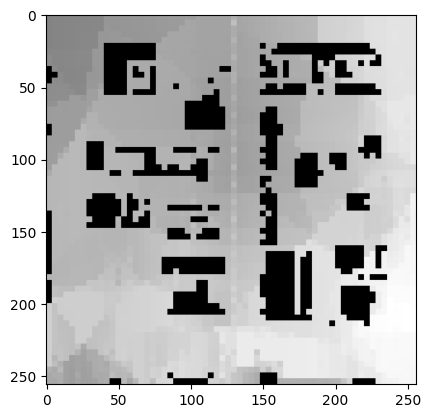

In [26]:
data, target = usc_test_data[0]

image = target[0,:,:].unsqueeze(0).permute(1,2,0)

plt.imshow(image.squeeze(), cmap='gray')
plt.show()

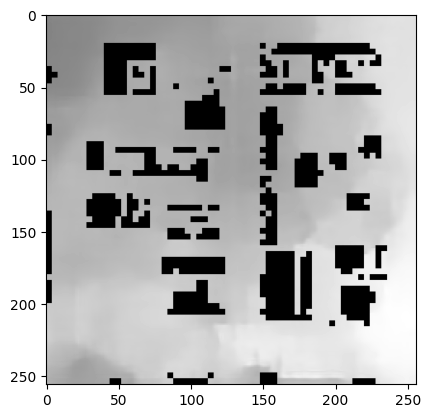

In [37]:
network.eval()
output = network(data.unsqueeze(0))

output_img = output.detach()[0,0,:,:].unsqueeze(0).permute(1,2,0)
output_img[data[0,:,:] == 1] = 0

plt.imshow(output_img.squeeze(), cmap='gray')
plt.show()

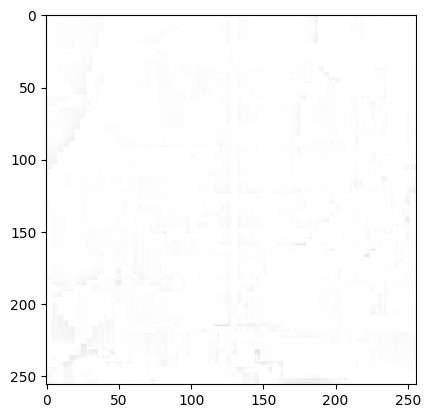

In [41]:
error_img = 1-(output_img - image)
plt.imshow(error_img.squeeze(), cmap='gray', vmin=0, vmax=1)
plt.show()